# 1D spectral analysis

### Objective
Performing a full spectral anaysis of the Crab pulsar.

### Steps
- Prepare the **data access and selection**
- Set up the **analyis parameters**
  - Define the [reconstructed energy](https://docs.gammapy.org/1.2/user-guide/references.html#term-Reco-Energy) axis and [true energy](https://docs.gammapy.org/1.2/user-guide/references.html#term-True-Energy) axis using the `~gammapy.maps.MapAxis` object
  - Define the spatial geometry
  - Define the exclusion mask
  - Choose the correct `~gammapy.datasets.Dataset` type and define it
- Do the **data reduction**
- Make **the modeling and fitting**
  - Define the `~gammapy.modeling.models.SkyModel` to fit the data. Being this a spectral analysis, the `SkyModel` is completely defined by a  `~gammapy.modeling.models.SpectralModel` (no spatial information is required)
  - Create a `~gammapy.modeling.Fit` object and run it to fit the model parameters
  - Apply a `~gammapy.estimators.FluxPointsEstimator` to compute flux points for the spectral part of the fit.

## Import all the necessary libraries for the tutorial

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion


from gammapy.data import DataStore
from gammapy.datasets import SpectrumDataset, Datasets
from gammapy.maps import MapAxis, WcsGeom, RegionGeom
from gammapy.makers import (
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker
)
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
)
from gammapy.visualization import plot_spectrum_datasets_off_regions

In [2]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")

#### Exercise:

**Utilise the above `data_store.obs_table` to display only "Crab Nebula" observations using the `OBJECT` column**

In [3]:
selection = data_store.obs_table['OBJECT']==['Crab Nebula']

In [4]:
obs_ids = data_store.obs_table[selection]["OBS_ID"]
observations = data_store.get_observations(obs_ids)

In [5]:
print(observations)

Observations
Number of observations: 4
Observation

	obs id            : 23523 
 	tstart            : 53343.92
	tstop             : 53343.94
	duration          : 1687.00 s
	pointing (icrs)   : 83.6 deg, 21.5 deg

	deadtime fraction : 6.2%
Observation

	obs id            : 23526 
 	tstart            : 53343.95
	tstop             : 53343.97
	duration          : 1683.00 s
	pointing (icrs)   : 83.6 deg, 22.5 deg

	deadtime fraction : 6.6%
Observation

	obs id            : 23559 
 	tstart            : 53345.96
	tstop             : 53345.98
	duration          : 1686.00 s
	pointing (icrs)   : 85.3 deg, 22.0 deg

	deadtime fraction : 6.4%
Observation

	obs id            : 23592 
 	tstart            : 53347.91
	tstop             : 53347.93
	duration          : 1686.00 s
	pointing (icrs)   : 82.0 deg, 22.0 deg

	deadtime fraction : 6.2%



The next step is to define a signal extraction region, also known as `on` region. In the simplest case this is just a CircleSkyRegion.

**Recall our target is the `Crab`.**

In [6]:
target_position = SkyCoord.from_name('Crab')

In [7]:
on_region = CircleSkyRegion(center=target_position, radius=0.11*u.deg)

## Exercise: create a geometry based on the target position, with a bin size of 0.05 and 150 pixel2.

In [8]:
geom = WcsGeom.create(
    npix=(150, 150), 
    binsz=0.05, 
    skydir=target_position, 
    frame="galactic"
)

We will use the reflected regions method to place off regions to estimate the background level in the on region. To make sure the off regions don’t contain gamma-ray emission, we create an exclusion mask.

Using http://gamma-sky.net/ we find that there’s only one known gamma-ray source near the Crab nebula:

<WCSAxes: >

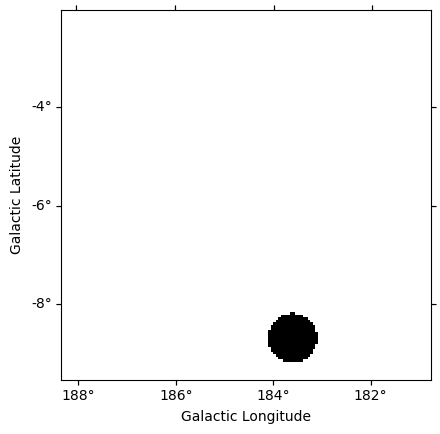

In [9]:
exclusion_region = CircleSkyRegion(
    center=SkyCoord(183.604, -8.708, unit="deg", frame="galactic"),
    radius=0.5 * u.deg,
)

exclusion_mask = ~geom.region_mask([exclusion_region])
exclusion_mask.plot()

In [10]:
energy_axis = MapAxis.from_energy_bounds(
    0.1, 40, nbin=10, per_decade=True, unit="TeV", name="energy"
)
energy_axis_true = MapAxis.from_energy_bounds(
    0.05, 100, nbin=20, per_decade=True, unit="TeV", name="energy_true"
)

geom = RegionGeom.create(region=on_region, axes=[energy_axis])

## Exercise

**Set up a `SpectrumDataset`, `SpectrumDatasetMaker`, `ReflectedRegionsBackgroundMaker` and `SafeMaskMaker`.**

In [11]:
dataset_empty = SpectrumDataset.create(
    geom=geom,
    energy_axis_true=energy_axis_true,
)
dataset_maker = SpectrumDatasetMaker(containment_correction=True)
bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)
safe_mask_masker = SafeMaskMaker(methods=["aeff-default"], aeff_percent=10)

In [12]:
datasets = Datasets()

for obs_id, observation in zip(obs_ids, observations):
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs_id)), observation)
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    datasets.append(dataset_on_off)

print(datasets)

Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : 23523
  Instrument : HESS
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : 23526
  Instrument : HESS
  Models     : 

Dataset 2: 

  Type       : SpectrumDatasetOnOff
  Name       : 23559
  Instrument : HESS
  Models     : 

Dataset 3: 

  Type       : SpectrumDatasetOnOff
  Name       : 23592
  Instrument : HESS
  Models     : 




/home/feijen/anaconda3/envs/gammapy-1.2-withray/lib/python3.10/site-packages/regions/shapes/circle.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)
/home/feijen/anaconda3/envs/gammapy-1.2-withray/lib/python3.10/site-packages/gammapy/visualization/datasets.py:84: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handle = Patch(**plot_kwargs)


<WCSAxes: >

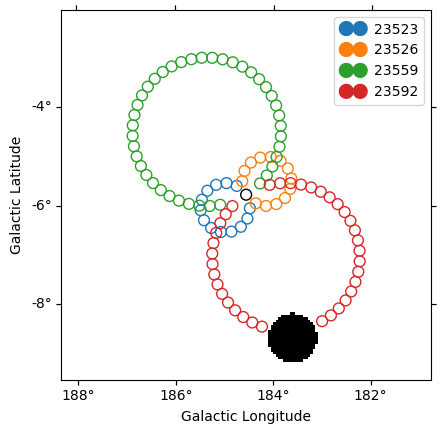

In [13]:
ax = exclusion_mask.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor="k")
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)

## Data Fitting

In this section we fit a spectral model to the data. In particular, we can use the [likelihood ratio test](https://docs.gammapy.org/1.2/user-guide/stats/index.html#estimating-ts) to compare two different hypotheses:
- H0: Background only (no source)
- H1: Background + source described by a power law model


### **H0**

The value of the quantity $-2\ln\mathcal(L)$ for the background-only model (null hypothesis) can be simply computed as

In [14]:
stacked_dataset = datasets.stack_reduce(name='stacked')
print(stacked_dataset)

SpectrumDatasetOnOff
--------------------

  Name                            : stacked 

  Total counts                    : 434 
  Total background counts         : 27.36
  Total excess counts             : 406.64

  Predicted counts                : 44.63
  Predicted background counts     : 44.63
  Predicted excess counts         : nan

  Exposure min                    : 2.10e+07 m2 s
  Exposure max                    : 2.64e+09 m2 s

  Number of total bins            : 27 
  Number of fit bins              : 18 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 1389.61

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 625 
  Acceptance                      : 18 
  Acceptance off                  : 468 



In [15]:
Wstat_0 = stacked_dataset.stat_sum()
print(Wstat_0)

1389.6144827914222


Since the background has been estimated using the reflected regions method, here $-2\ln\mathcal(L)$ corresponds to the so-called [Wstat](https://docs.gammapy.org/1.2/user-guide/references.html#term-WStat) fit statistic.

We can inspect the model residuals for the H0 hypothesis:

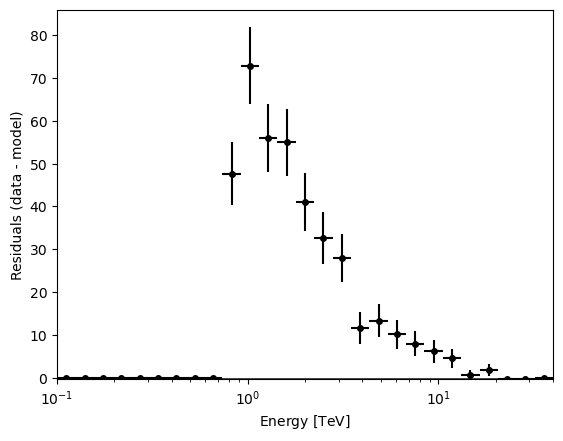

In [16]:
stacked_dataset.plot_residuals_spectral();

As expected, the residuals show a clear positive feature indicating that a source is missing in the model.

## **H1**
We now add a source defined by a power law spectrum to the model.

In [17]:
spectral_model = PowerLawSpectralModel(
    index=2.2, amplitude=2e-11 * u.Unit("1 / (cm2 s TeV)"), reference=1 * u.TeV
)

**Define your `SkyModel` and apply it to your `stacked_dataset`.**

In [18]:
model1 = SkyModel(spectral_model=spectral_model, name='source')

In [19]:
stacked_dataset.models = [model1]

**Create the `Fit` object, and run the fit.**

In [20]:
fit = Fit()
result1 = fit.run(stacked_dataset)

In [21]:
Wstat_1 = result1.total_stat
print(f"delta TS of H1 vs H0: {Wstat_0-Wstat_1}")

delta TS of H1 vs H0: 1374.9446501688942


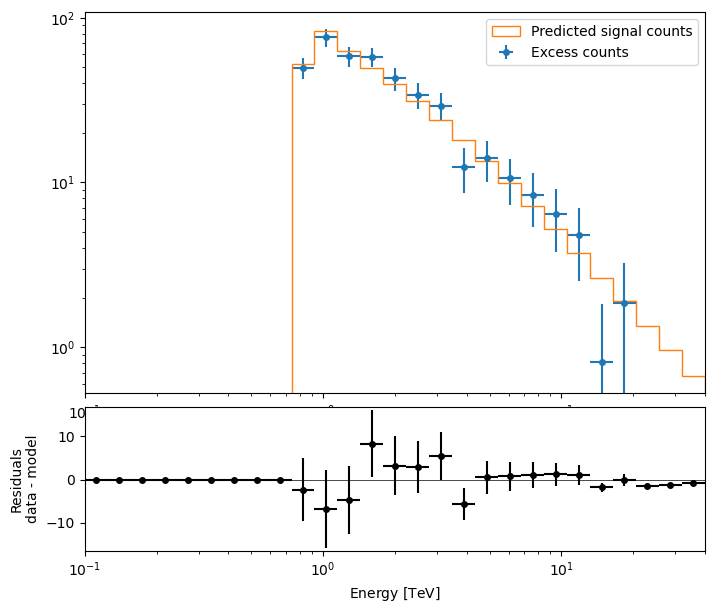

In [22]:
ax_spectrum, ax_residuals = stacked_dataset.plot_fit()